### Things I have done in this file:
1. Calling the required libraries.
2. Importing the inbuilt IMDB reviews dataset.
3. Exploring the data, resetting the indices.
4. Building word cloud on first 200 reviews.
5. Dciding the maximum length of a review.
6. Calling GloVe embeddings, building embedding matrix for the words in the IMDB dataset.
7. Building Bidirectional LSTM model.

## Calling the Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import gensim
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords

from tensorflow.keras.datasets import imdb 
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Embedding, Dense, Flatten 
from tensorflow.keras.layers import Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import classification_report,confusion_matrix

Fixing random seed for reproducibility

In [3]:
np.random.seed(123)
tf.random.set_seed(123)

#### Loading the IMDB Dataset

In [4]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()

Understanding the data

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [6]:
print(X_train[0])
print("\n")
print("label - ",y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


label -  1


In [7]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [8]:
print(np.min(np.min(X_train)))
print(np.max(np.max(X_train)))

1
88325


Import the word_index dictionary

In [9]:
word_index = dict([(key, value + 3) for (key, value) in imdb.get_word_index().items()])
# The index has to adjusted according to load_data function shown above. 
# Because the 'index_from' is set to 3 in load_data function, we need to add 3 to all the word indices. 
# Also, the indices upto 3 can be filled with appropriate tokens as shown below

In [10]:
word_index1 = dict([(key, value) for (key, value) in imdb.get_word_index().items()])
word_index1.get('this')

11

In [11]:
word_index.get('this')

14

In [12]:
dict(list(imdb.get_word_index().items())[0:10])

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008}

In [13]:
dict(list(word_index.items())[0:10])

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011}

Adding the indices as mentioned in the inbuilt dataset

In [14]:
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3

In [15]:
print(min(word_index.values()))
print(max(word_index.values()))
print(len(word_index))

0
88587
88588


In [16]:
index_word = dict([(value, key) for (key, value) in word_index.items()])

In [17]:
list(index_word.items())[0:10]

[(34704, 'fawn'),
 (52009, 'tsukino'),
 (52010, 'nunnery'),
 (16819, 'sonja'),
 (63954, 'vani'),
 (1411, 'woods'),
 (16118, 'spiders'),
 (2348, 'hanging'),
 (2292, 'woody'),
 (52011, 'trawling')]

In [18]:
!pip install sortedcontainers

In [19]:
from sortedcontainers import SortedDict

total_sorted_index = SortedDict(index_word)

In [20]:
print(dict(list(total_sorted_index.items())[0:200]))

{0: '<PAD>', 1: '<START>', 2: '<UNK>', 3: '<UNUSED>', 4: 'the', 5: 'and', 6: 'a', 7: 'of', 8: 'to', 9: 'is', 10: 'br', 11: 'in', 12: 'it', 13: 'i', 14: 'this', 15: 'that', 16: 'was', 17: 'as', 18: 'for', 19: 'with', 20: 'movie', 21: 'but', 22: 'film', 23: 'on', 24: 'not', 25: 'you', 26: 'are', 27: 'his', 28: 'have', 29: 'he', 30: 'be', 31: 'one', 32: 'all', 33: 'at', 34: 'by', 35: 'an', 36: 'they', 37: 'who', 38: 'so', 39: 'from', 40: 'like', 41: 'her', 42: 'or', 43: 'just', 44: 'about', 45: "it's", 46: 'out', 47: 'has', 48: 'if', 49: 'some', 50: 'there', 51: 'what', 52: 'good', 53: 'more', 54: 'when', 55: 'very', 56: 'up', 57: 'no', 58: 'time', 59: 'she', 60: 'even', 61: 'my', 62: 'would', 63: 'which', 64: 'only', 65: 'story', 66: 'really', 67: 'see', 68: 'their', 69: 'had', 70: 'can', 71: 'were', 72: 'me', 73: 'well', 74: 'than', 75: 'we', 76: 'much', 77: 'been', 78: 'bad', 79: 'get', 80: 'will', 81: 'do', 82: 'also', 83: 'into', 84: 'people', 85: 'other', 86: 'first', 87: 'great', 8

In [21]:
y_train

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

### Building word cloud images

In [22]:
def seq2text(arrays):
    sentences = pd.DataFrame({'Review': [], 'Sentiment': []})
    for x in range(len(arrays)):
        a = ' '.join([index_word.get(i) for i in arrays[x]])
        b = y_train[x]
        sentences.loc[x, 'Review'] = a
        sentences.loc[x, 'Sentiment'] = b
    return sentences

In [23]:
reviews = seq2text(X_train[0:100])
reviews.head()

,Review,Sentiment
0,<START> this film was just brilliant casting l...,1.0
1,<START> big hair big boobs bad music and a gia...,0.0
2,<START> this has to be one of the worst films ...,0.0
3,<START> the scots excel at storytelling the tr...,1.0
4,<START> worst mistake of my life br br i picke...,0.0


In [24]:
import string
def remove_punc(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)

    return Test_punc_removed_join

In [25]:
reviews['Text Without Punctuation'] = reviews['Review'].apply(remove_punc)

In [26]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['movie','cinema', "<PAD>", '<START>', "<UNK>", "<UNUSED>", 'pad', 'start', 'unk', 'unused', 'film'])

In [27]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return result

In [28]:
reviews['without stop words'] = reviews['Review'].apply(preprocess)
reviews.head()

,Review,Sentiment,Text Without Punctuation,without stop words
0,<START> this film was just brilliant casting l...,1.0,START this film was just brilliant casting loc...,"[brilliant, casting, location, scenery, story,..."
1,<START> big hair big boobs bad music and a gia...,0.0,START big hair big boobs bad music and a giant...,"[big, hair, big, boobs, bad, music, giant, saf..."
2,<START> this has to be one of the worst films ...,0.0,START this has to be one of the worst films of...,"[one, worst, films, friends, watching, target,..."
3,<START> the scots excel at storytelling the tr...,1.0,START the scots excel at storytelling the trad...,"[scots, excel, storytelling, traditional, sort..."
4,<START> worst mistake of my life br br i picke...,0.0,START worst mistake of my life br br i picked ...,"[worst, mistake, life, picked, target, figured..."


In [29]:
reviews['final output'] = reviews['without stop words'].apply(lambda x: " ".join(x))
reviews.head()

,Review,Sentiment,Text Without Punctuation,without stop words,final output
0,<START> this film was just brilliant casting l...,1.0,START this film was just brilliant casting loc...,"[brilliant, casting, location, scenery, story,...",brilliant casting location scenery story direc...
1,<START> big hair big boobs bad music and a gia...,0.0,START big hair big boobs bad music and a giant...,"[big, hair, big, boobs, bad, music, giant, saf...",big hair big boobs bad music giant safety pin ...
2,<START> this has to be one of the worst films ...,0.0,START this has to be one of the worst films of...,"[one, worst, films, friends, watching, target,...",one worst films friends watching target audien...
3,<START> the scots excel at storytelling the tr...,1.0,START the scots excel at storytelling the trad...,"[scots, excel, storytelling, traditional, sort...",scots excel storytelling traditional sort many...
4,<START> worst mistake of my life br br i picke...,0.0,START worst mistake of my life br br i picked ...,"[worst, mistake, life, picked, target, figured...",worst mistake life picked target figured hey s...


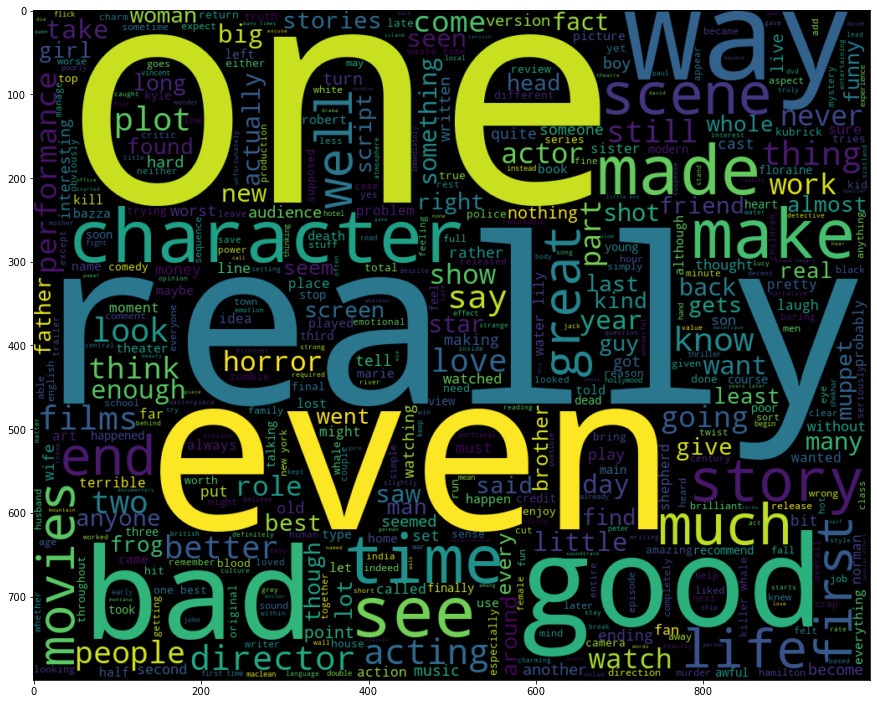

In [30]:
plt.figure(figsize=(15,15))
wc = WordCloud(max_words=500, width=1000, height=800).generate(" ".join(reviews['final output']))
plt.imshow(wc, interpolation='bilinear');

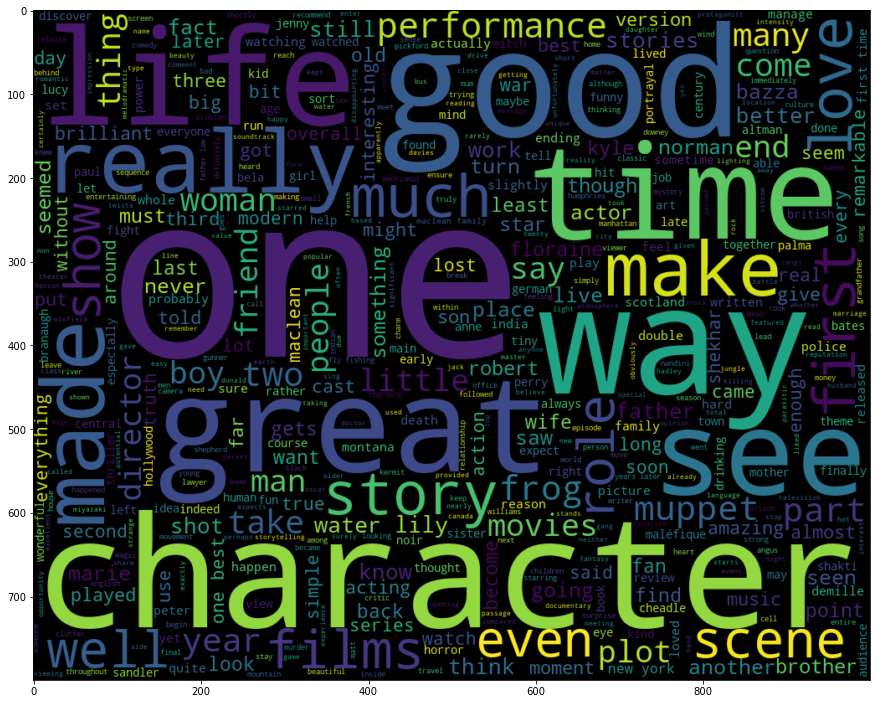

In [31]:
plt.figure(figsize=(15,15))
wc = WordCloud(max_words=500, width=1000, height=800).generate(" ".join(reviews[reviews['Sentiment'] == 1]['final output']))
plt.imshow(wc, interpolation='bilinear');

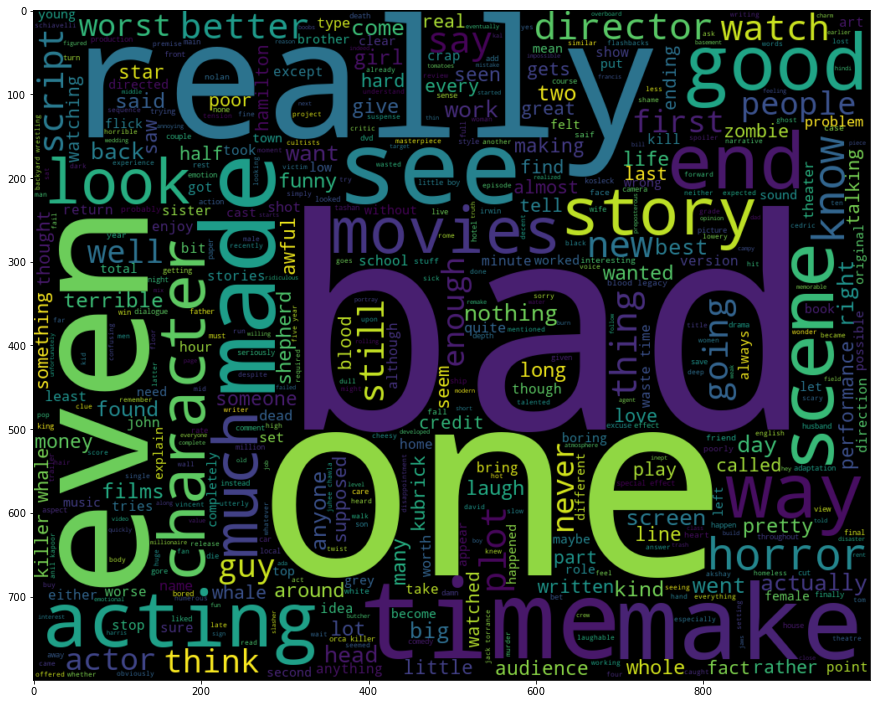

In [32]:
plt.figure(figsize=(15,15))
wc = WordCloud(max_words=500, width=1000, height=800).generate(" ".join(reviews[reviews['Sentiment'] == 0]['final output']))
plt.imshow(wc, interpolation='bilinear');

### Deciding the maximum length of review so that we can either pad or truncate in the end

In [33]:
def max_length(data):
    length = []
    for a in range(len(data)):
        length.append(len(data[a]))
    
    length = sorted(length)
    
    return length
    

In [34]:
x = max_length(X_train)

In [35]:
morethan_500 = 0
for i in range(len(x)):
    if x[i] > 500:
        morethan_500 += 1

In [36]:
max(x)

2494

In [37]:
morethan_500

2108

In [38]:
y = max_length(X_test)
max(y)

2315

In [39]:
morethan_500_test = 0
for i in range(len(y)):
    if y[i] > 500:
        morethan_500_test += 1

In [40]:
morethan_500_test

1925

#### Max length is 2494 but there are only 2315 strings (less than 10%) which are having a length of more than 500, if we have 2500 as the length, we might get a sparse matrix, so it's better to reduce it to a length of 500.

#####  Truncate or pad the input sequences so that they are all the same length for modeling.

In [41]:
max_seq_length = 500

X_train = sequence.pad_sequences(X_train, maxlen= max_seq_length, padding= 'post', truncating= 'post')
X_test = sequence.pad_sequences(X_test, maxlen= max_seq_length, padding= 'post', truncating= 'post')

In [42]:
print(X_train[0], '\n', y_train[0])

[    1    14    22    16    43   530   973  1622  1385    65   458  4468
    66  3941     4   173    36   256     5    25   100    43   838   112
    50   670 22665     9    35   480   284     5   150     4   172   112
   167 21631   336   385    39     4   172  4536  1111    17   546    38
    13   447     4   192    50    16     6   147  2025    19    14    22
     4  1920  4613   469     4    22    71    87    12    16    43   530
    38    76    15    13  1247     4    22    17   515    17    12    16
   626    18 19193     5    62   386    12     8   316     8   106     5
     4  2223  5244    16   480    66  3785    33     4   130    12    16
    38   619     5    25   124    51    36   135    48    25  1415    33
     6    22    12   215    28    77    52     5    14   407    16    82
 10311     8     4   107   117  5952    15   256     4 31050     7  3766
     5   723    36    71    43   530   476    26   400   317    46     7
     4 12118  1029    13   104    88     4   381   

#### I used Glove Embeddings, because they have a good representation of the words and I don't want to build the words' weights from the scratch, it's time consuming

In [43]:
word_embeddings = dict()

f = open('glove.6B.50d.txt', encoding='utf8')

for line in f:
    values = line.split()
    word = values[0]
    embedding_vector = np.asarray(values[1:], dtype = 'float32')
    word_embeddings[word] = embedding_vector
    
f.close()

print('Length of word embeddings is: %s' % len(word_embeddings))

Length of word embeddings is: 400000


In [44]:
dict(list(word_embeddings.items())[0:5])

{'the': array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
       dtype=float32),
 ',': array([ 0.013441,  0.23682 , -0.16899 ,  0.40951 ,  0.63812 ,  0.47709 ,
        -0.42852 , -0.55641 , -0.364   , -0.23938 ,  0.13001 , -0.063734,
        -0.39575 , -0.48162 ,  0.23291 ,  0.090201, -0.13324 ,  0.078639,
        -0.4

##### Creating a embedding matrix cosisting of all zeros for all words in the word list of our dataset each one with a length of 100. After creating that, we replace the zeros with the embedding we have called from the Glove.

In [45]:
vocab_size = len(word_index)
vocab_size

88588

In [46]:
embedding_vector_length = 50

embedding_matrix = np.zeros((vocab_size,embedding_vector_length))

for word, i in word_index.items():
    embedding_vector = word_embeddings.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [47]:
print(index_word[4])
print(word_embeddings['the'])
print(embedding_matrix[4])

the
[ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]
[ 4.18000013e-01  2.49679998e-01 -4.12420005e-01  1.21699996e-01
  3.45270008e-01 -4.44569997e-02 -4.96879995e-01 -1.78619996e-01
 -6.60229998e-04 -6.56599998e-01  2.78430015e-01 -1.47670001e-01
 -5.56770027e-01  1.46579996e-01 -9.50950012e-03  1.16579998e-02
  1.02040000e-01 -1.27920002e-01 -8.44299972e-01 -1.21809997e-01
 -1.68009996e-02 -3.32789987e-01 -1.55200005e-01 -2.31309995e

In [48]:
X_train.shape

(25000, 500)

In [49]:
X_test.shape

(25000, 500)

### Building RNN using bidirectional LSTM

In [50]:
arr = y_train  
y_train = np.zeros((arr.size, arr.max()+1))  # initialize empty (all zero) label array
y_train[np.arange(arr.size), arr] = 1  # add ones in indices where we have a value
y_train

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [51]:
arr = y_test  
y_test = np.zeros((arr.size, arr.max()+1))  # initialize empty (all zero) label array
y_test[np.arange(arr.size), arr] = 1  # add ones in indices where we have a value
y_test

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [52]:
print(max_seq_length)
print(embedding_vector_length)
print(vocab_size)

500
50
88588


In [53]:
input_layer = Input(shape=(max_seq_length,),dtype='int32')
hl1_embedded = Embedding(input_dim = vocab_size,
                        output_dim = embedding_vector_length,
                        weights = [embedding_matrix],
                        trainable = True)(input_layer)

hl2 = Bidirectional(tf.keras.layers.LSTM(64))(hl1_embedded)
hl3 = Dropout(0.2)(hl2)

hl4 = Dense(32, activation='relu', kernel_initializer='glorot_normal')(hl3)
hl5 = Dropout(0.2)(hl4)

hl6 = Dense(16, activation='relu', kernel_initializer='glorot_normal')(hl5)
hl7 = Dropout(0.15)(hl6)

hl8 = Dense(8, activation='relu', kernel_initializer='glorot_normal')(hl7)
hl9 = Dropout(0.1)(hl8)

output = Dense(2, activation='softmax')(hl9)

model = Model(input_layer,output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 50)           4429400   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               58880     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528   

In [54]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=tf.keras.metrics.CategoricalAccuracy())

In [55]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1, min_delta=0.001)
callbacks=[early_stopping]

In [56]:
model.fit(X_train, y_train, epochs=4,
          validation_split=0.3,
          batch_size=32,callbacks=callbacks)

Epoch 1/4
547/547 [==============================] - 231s 415ms/step - loss: 0.6892 - categorical_accuracy: 0.5304 - val_loss: 0.6464 - val_categorical_accuracy: 0.6499
Epoch 2/4
547/547 [==============================] - 222s 405ms/step - loss: 0.6670 - categorical_accuracy: 0.6083 - val_loss: 0.4982 - val_categorical_accuracy: 0.7804
Epoch 3/4
547/547 [==============================] - 236s 431ms/step - loss: 0.4098 - categorical_accuracy: 0.8385 - val_loss: 0.3386 - val_categorical_accuracy: 0.8573
Epoch 4/4
547/547 [==============================] - 252s 461ms/step - loss: 0.2436 - categorical_accuracy: 0.9166 - val_loss: 0.3153 - val_categorical_accuracy: 0.8737


In [57]:
Y_train_pred = model.predict(X_train)

In [58]:
y_train_pred =[]
for i in Y_train_pred:
    y_train_pred.append(np.argmax(i))

In [59]:
y_train_pred[0:10]

[1, 0, 0, 1, 0, 0, 1, 0, 1, 0]

In [60]:
Y_train =[]
for i in y_train:
    Y_train.append(np.argmax(i))

In [61]:
Y_train[0:10]

[1, 0, 0, 1, 0, 0, 1, 0, 1, 0]

In [62]:
Y_pred = model.predict(X_test)
print(Y_pred[0:10])

[[0.9074207  0.09257926]
 [0.00470089 0.9952991 ]
 [0.00239508 0.99760485]
 [0.9157284  0.08427159]
 [0.43151745 0.5684825 ]
 [0.63825494 0.36174503]
 [0.5354251  0.46457487]
 [0.9023068  0.09769327]
 [0.1100169  0.8899831 ]
 [0.34724826 0.65275174]]


In [63]:
y_pred =[]
for i in Y_pred:
    y_pred.append(np.argmax(i))

In [64]:
print(y_pred[0:50])

[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]


In [65]:
y_test

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [66]:
Y_test =[]
for i in y_test:
    Y_test.append(np.argmax(i))

In [67]:
print(Y_test[0:50])

[0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1]


In [68]:
print(confusion_matrix(Y_test, y_pred))

[[11231  1269]
 [ 2144 10356]]


In [69]:
print(classification_report(Y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94     12500
           1       0.95      0.92      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000



In [70]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87     12500
           1       0.89      0.83      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.87      0.86      0.86     25000
weighted avg       0.87      0.86      0.86     25000



### Here I got weighted F1 scores of 0.93 on train data and 0.86 on test data. There is some overfitting but due to computationally it's so much time consuming, I had to stop at this point.